# Plot census data using geopandas

In [2]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame

import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile

import matplotlib.pyplot as plt

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
zip_f = "nyc/tl_2020_36_tract.zip"

In [4]:
census_geo = gpd.read_file(zip_f)

In [5]:
census_geo.head(3)

STATEFP COUNTYFP TRACTCE        GEOID NAME         NAMELSAD  MTFCC FUNCSTAT  \
0      36      047  000700  36047000700    7   Census Tract 7  G5020        S   
1      36      047  000900  36047000900    9   Census Tract 9  G5020        S   
2      36      047  001100  36047001100   11  Census Tract 11  G5020        S   

    ALAND  AWATER     INTPTLAT      INTPTLON  \
0  176774       0  +40.6923505  -073.9973434   
1  163469       0  +40.6917206  -073.9916018   
2  168507       0  +40.6932903  -073.9877087   

                                            geometry  
0  POLYGON ((-74.00154 40.69279, -74.00132 40.693...  
1  POLYGON ((-73.99405 40.69090, -73.99374 40.691...  
2  POLYGON ((-73.99073 40.69305, -73.99045 40.693...

In [6]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [7]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [8]:
combined = census_geo.merge(commute, on='GEOID')

## Examining the comuting census data

## Examining the household census data

In [9]:
new_census = pd.read_csv('nyc/protected_attributes_ny_AMC2020_5year.csv', skiprows=[1])

In [10]:
new_census.head().T

0  \
FIPS                                                                36001000100   
Qualifying Name                         Census Tract 1, Albany County, New York   
File identification                                                       ACSSF   
State Postal Abbreviation                                                    ny   
Summary Level                                                               140   
...                                                                         ...   
Households: 3-Person Household                                              149   
Households: 4-Person Household                                               58   
Households: 5-Person Household                                               95   
Households: 6-Person Household                                               17   
Households: 7-or-More Person Household                                        3   

                                                                                 1  \
FIPS                                                                   36001000201   
Qualifying Name                         Census Tract 2.01, Albany County, New York   
File identification                                                          ACSSF   
State Postal Abbreviation                                                       ny   
Summary Level                                                                  140   
...                                                                            ...   
Households: 3-Person Household                                                  63   
Households: 4-Person Household                                                 143   
Households: 5-Person Household                                                 102   
Households: 6-Person Household                                                   0   
Households: 7-or-More Person Household                                           0   

                                                                                 2  \
FIPS                                                                   36001000202   
Qualifying Name                         Census Tract 2.02, Albany County, New York   
File identification                                                          ACSSF   
State Postal Abbreviation                                                       ny   
Summary Level                                                                  140   
...                                                                            ...   
Households: 3-Person Household                                                 215   
Households: 4-Person Household                                                 135   
Households: 5-Person Household                                                  69   
Households: 6-Person Household                                                   0   
Households: 7-or-More Person Household                                           0   

                                                                                 3  \
FIPS                                                                   36001000301   
Qualifying Name                         Census Tract 3.01, Albany County, New York   
File identification                                                          ACSSF   
State Postal Abbreviation                                                       ny   
Summary Level                                                                  140   
...                                                                            ...   
Households: 3-Person Household                                                 293   
Households: 4-Person Household                                                   0   
Households: 5-Person Household                                                  51   
Households: 6-Person Household                                                 112   
Households: 7-or-More Person Household                               

In [11]:
new_census.columns[:20]

Index(['FIPS', 'Qualifying Name', 'File identification',
       'State Postal Abbreviation', 'Summary Level', 'Geographic Component',
       'Logical Record Number', 'US', 'Census Region', 'Census Division',
       'State (Census Code)', 'State (FIPS Code)',
       'County of current residence', 'County Subdivision (FIPS)',
       'Place (FIPS Code)', 'Census Tract', 'Block Group', 'Consolidated City',
       'American Indian Area/Alaska Native Area/ Hawaiian Home Land (Census)',
       'American Indian Area/Alaska Native Area/ Hawaiian Home Land (FIPS)'],
      dtype='object')

In [12]:
census_df = pd.DataFrame()

In [13]:
pop_sex_columns = ["Total Population: Male",
                   "Total Population: Female",
                   "Total Population:"]
new_census[pop_sex_columns].info()
new_census[pop_sex_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total Population: Male    5411 non-null   int64
 1   Total Population: Female  5411 non-null   int64
 2   Total Population:         5411 non-null   int64
dtypes: int64(3)
memory usage: 126.9 KB


Total Population: Male  Total Population: Female  Total Population:
0                     890                      1139               2029
1                    1427                      1836               3263
2                    1059                      1094               2153
3                    1347                      1669               3016
4                    1287                      1644               2931

In [14]:
census_df["male_population"] = new_census["Total Population: Male"] 
census_df["female_population"] = new_census["Total Population: Female"] 

In [15]:
census_df["total_population"] = new_census["Total Population:"]

In [16]:
pop_race_columns = ["Total Population: White Alone",
                    "Total Population: Black or African American Alone",
                    "Total Population: American Indian and Alaska Native Alone",
                    "Total Population: Asian Alone",
                    "Total Population: Native Hawaiian and Other Pacific Islander Alone",
                    "Total Population: Some Other Race Alone",
                    "Total Population: Two or More Races"]
new_census[pop_race_columns].info()
new_census[pop_race_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 7 columns):
 #   Column                                                              Non-Null Count  Dtype
---  ------                                                              --------------  -----
 0   Total Population: White Alone                                       5411 non-null   int64
 1   Total Population: Black or African American Alone                   5411 non-null   int64
 2   Total Population: American Indian and Alaska Native Alone           5411 non-null   int64
 3   Total Population: Asian Alone                                       5411 non-null   int64
 4   Total Population: Native Hawaiian and Other Pacific Islander Alone  5411 non-null   int64
 5   Total Population: Some Other Race Alone                             5411 non-null   int64
 6   Total Population: Two or More Races                                 5411 non-null   int64
dtypes: int64(7)
memory usage: 296.0 KB

Total Population: White Alone  \
0                            481   
1                            643   
2                             86   
3                            847   
4                           1936   

   Total Population: Black or African American Alone  \
0                                               1141   
1                                               2230   
2                                               1968   
3                                               1116   
4                                                469   

   Total Population: American Indian and Alaska Native Alone  \
0                                                 28           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   Total Population: Asian Alone  \
0                             99   
1                             89   
2                              0   
3                            393   
4                            257   

   Total Population: Native Hawaiian and Other Pacific Islander Alone  \
0                                                  0                    
1                                                  0                    
2                                                  0                    
3                                                  0                    
4                                                  0                    

   Total Population: Some Other Race Alone  \
0                                       62   
1                                        0   
2                                        0   
3                                       79   
4                                       60   

   Total Population: Two or More Races  
0                                  218  
1                                  301  
2                                   99  
3                                  581  
4                                  209

In [17]:
census_df["total_population_white"] = new_census["Total Population: White Alone"] 
census_df["total_population_black"] = new_census["Total Population: Black or African American Alone"]
census_df["total_population_two_ormore_races"] = new_census["Total Population: Two or More Races"]
census_df["total_population_asian"] = new_census["Total Population: Asian Alone"] 


In [18]:
census_df.head()

male_population  female_population  total_population  \
0              890               1139              2029   
1             1427               1836              3263   
2             1059               1094              2153   
3             1347               1669              3016   
4             1287               1644              2931   

   total_population_white  total_population_black  \
0                     481                    1141   
1                     643                    2230   
2                      86                    1968   
3                     847                    1116   
4                    1936                     469   

   total_population_two_ormore_races  total_population_asian  
0                                218                      99  
1                                301                      89  
2                                 99                       0  
3                                581                     393  
4                                209                     257

In [19]:
pop_education_columns = ["Population 25 Years and Over:",
                        "Population 25 Years and Over: Less than High School",
                        "Population 25 Years and Over: High School Graduate (Includes Equivalency)",
                        "Population 25 Years and Over: Some College",
                        "Population 25 Years and Over: Bachelor's Degree",
                        "Population 25 Years and Over: Master's Degree",
                        "Population 25 Years and Over: Professional School Degree",
                        "Population 25 Years and Over: Doctorate Degree"]
new_census[pop_education_columns].info()
new_census[pop_education_columns].head()

census_df["population_over_25"] = new_census["Population 25 Years and Over:"]
census_df["population_over_25_no_highschool"] = new_census["Population 25 Years and Over: Less than High School"]
census_df["population_over_25_highschool"] = new_census["Population 25 Years and Over: High School Graduate (Includes Equivalency)"] 
census_df["population_over_25_bachelor"] = new_census["Population 25 Years and Over: Bachelor's Degree"]
census_df["population_over_25_master"] = new_census["Population 25 Years and Over: Master's Degree"] 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 8 columns):
 #   Column                                                                     Non-Null Count  Dtype
---  ------                                                                     --------------  -----
 0   Population 25 Years and Over:                                              5411 non-null   int64
 1   Population 25 Years and Over: Less than High School                        5411 non-null   int64
 2   Population 25 Years and Over: High School Graduate (Includes Equivalency)  5411 non-null   int64
 3   Population 25 Years and Over: Some College                                 5411 non-null   int64
 4   Population 25 Years and Over: Bachelor's Degree                            5411 non-null   int64
 5   Population 25 Years and Over: Master's Degree                              5411 non-null   int64
 6   Population 25 Years and Over: Professional School Degree                 

In [20]:
pop_occupation_columns = ["Population 16 Years and Over:",
                          "Civilian Population 16 to 19 Years: Not High School Graduate, Not Enrolled (Dropped Out)",
                          "Civilian Population 16 to 19 Years: High School Graduate, or Enrolled (In School)",
                          "Population 16 Years and Over: in Labor Force",
                          "Population 16 Years and Over: in Labor Force: in Armed Forces",
                          "Population 16 Years and Over: in Labor Force: Civilian",
                          "Population 16 Years and Over: in Labor Force: Civilian: Employed",
                          "Population 16 Years and Over: in Labor Force: Civilian: Unemployed",
                          "Population 16 Years and Over: Not in Labor Force"]
new_census[pop_occupation_columns].info()
new_census[pop_occupation_columns].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 9 columns):
 #   Column                                                                                    Non-Null Count  Dtype
---  ------                                                                                    --------------  -----
 0   Population 16 Years and Over:                                                             5411 non-null   int64
 1   Civilian Population 16 to 19 Years: Not High School Graduate, Not Enrolled (Dropped Out)  5411 non-null   int64
 2   Civilian Population 16 to 19 Years: High School Graduate, or Enrolled (In School)         5411 non-null   int64
 3   Population 16 Years and Over: in Labor Force                                              5411 non-null   int64
 4   Population 16 Years and Over: in Labor Force: in Armed Forces                             5411 non-null   int64
 5   Population 16 Years and Over: in Labor Force: Civilian                

Population 16 Years and Over:  \
0                           1553   
1                           2801   
2                           1482   
3                           2297   
4                           2580   

   Civilian Population 16 to 19 Years: Not High School Graduate, Not Enrolled (Dropped Out)  \
0                                                 28                                          
1                                                  0                                          
2                                                  0                                          
3                                                  0                                          
4                                                  0                                          

   Civilian Population 16 to 19 Years: High School Graduate, or Enrolled (In School)  \
0                                                210                                   
1                                                322                                   
2                                                 27                                   
3                                                280                                   
4                                                 64                                   

   Population 16 Years and Over: in Labor Force  \
0                                          1050   
1                                          1993   
2                                          1034   
3                                          1523   
4                                          1602   

   Population 16 Years and Over: in Labor Force: in Armed Forces  \
0                                                 13               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   Population 16 Years and Over: in Labor Force: Civilian  \
0                                               1037        
1                                               1993        
2                                               1034        
3                                               1523        
4                                               1602        

   Population 16 Years and Over: in Labor Force: Civilian: Employed  \
0                                                870                  
1                                               1902                  
2                                                896                  
3                                               1377                  
4                                               1517                  

   Population 16 Years and Over: in Labor Force: Civilian: Unemployed  \
0                                                167                    
1                                                 91                    
2                                                138                    
3                                                146                    
4                                                 85                    

   Population 16 Years and Over: Not in Labor Force  
0                                               503  
1                                               808  
2                                               448  
3                                               774  
4                                               978

In [21]:
census_df.columns

Index(['male_population', 'female_population', 'total_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'population_over_25', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master'],
      dtype='object')

In [22]:
pop_household_income_columns = ["Households:",
                                "Households: Less than $10,000",
                                "Households: $10,000 to $14,999",
                                "Households: $15,000 to $19,999",
                                "Households: $20,000 to $24,999",
                                "Households: $25,000 to $29,999",
                                "Households: $30,000 to $34,999",
                                "Households: $35,000 to $39,999",
                                "Households: $40,000 to $44,999",
                                "Households: $45,000 to $49,999",
                                "Households: $50,000 to $59,999",
                                "Households: $60,000 to $74,999",
                                "Households: $75,000 to $99,999",
                                "Households: $100,000 to $124,999",
                                "Households: $125,000 to $149,999",
                                "Households: $150,000 to $199,999",
                                "Households: $200,000 or More"]

new_census[pop_household_income_columns].info()
new_census[pop_household_income_columns].head()

census_df["households"] = new_census["Households:"]
census_df["households_0_to_50,000"] = new_census[["Households: Less than $10,000",
                                                    "Households: $10,000 to $14,999",
                                                    "Households: $15,000 to $19,999",
                                                    "Households: $20,000 to $24,999",
                                                    "Households: $25,000 to $29,999",
                                                    "Households: $30,000 to $34,999",
                                                    "Households: $35,000 to $39,999",
                                                    "Households: $40,000 to $44,999",
                                                    "Households: $45,000 to $49,999"]].sum(axis=1) 
census_df["households_over_50,000"] = new_census[["Households: $50,000 to $59,999",
                                                    "Households: $60,000 to $74,999",
                                                    "Households: $75,000 to $99,999",
                                                    "Households: $100,000 to $124,999",
                                                    "Households: $125,000 to $149,999",
                                                    "Households: $150,000 to $199,999",
                                                    "Households: $200,000 or More"]].sum(axis=1) 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Households:                       5411 non-null   int64
 1   Households: Less than $10,000     5411 non-null   int64
 2   Households: $10,000 to $14,999    5411 non-null   int64
 3   Households: $15,000 to $19,999    5411 non-null   int64
 4   Households: $20,000 to $24,999    5411 non-null   int64
 5   Households: $25,000 to $29,999    5411 non-null   int64
 6   Households: $30,000 to $34,999    5411 non-null   int64
 7   Households: $35,000 to $39,999    5411 non-null   int64
 8   Households: $40,000 to $44,999    5411 non-null   int64
 9   Households: $45,000 to $49,999    5411 non-null   int64
 10  Households: $50,000 to $59,999    5411 non-null   int64
 11  Households: $60,000 to $74,999    5411 non-null   int64
 12  Households: $75,000 to $99,999    

In [23]:
pop_household_price_columns = [ "Owner-Occupied Housing Units:",
                                "Owner-Occupied Housing Units: Less than $20,000",
                                "Owner-Occupied Housing Units: $20,000 to $49,999",
                                "Owner-Occupied Housing Units: $50,000 to $99,999",
                                "Owner-Occupied Housing Units: $100,000 to $149,999",
                                "Owner-Occupied Housing Units: $150,000 to $299,999",
                                "Owner-Occupied Housing Units: $300,000 to $499,999",
                                "Owner-Occupied Housing Units: $500,000 to $749,999",
                                "Owner-Occupied Housing Units: $750,000 to $999,999",
                                "Owner-Occupied Housing Units: $1,000,000 or More"]
new_census[pop_household_price_columns].info()
new_census[pop_household_price_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 10 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   Owner-Occupied Housing Units:                       5411 non-null   int64
 1   Owner-Occupied Housing Units: Less than $20,000     5411 non-null   int64
 2   Owner-Occupied Housing Units: $20,000 to $49,999    5411 non-null   int64
 3   Owner-Occupied Housing Units: $50,000 to $99,999    5411 non-null   int64
 4   Owner-Occupied Housing Units: $100,000 to $149,999  5411 non-null   int64
 5   Owner-Occupied Housing Units: $150,000 to $299,999  5411 non-null   int64
 6   Owner-Occupied Housing Units: $300,000 to $499,999  5411 non-null   int64
 7   Owner-Occupied Housing Units: $500,000 to $749,999  5411 non-null   int64
 8   Owner-Occupied Housing Units: $750,000 to $999,999  5411 non-null   int64
 9   Owner-Occupied Hous

Owner-Occupied Housing Units:  \
0                            280   
1                            265   
2                            257   
3                            311   
4                            586   

   Owner-Occupied Housing Units: Less than $20,000  \
0                                                6   
1                                                4   
2                                               61   
3                                               51   
4                                               12   

   Owner-Occupied Housing Units: $20,000 to $49,999  \
0                                                13   
1                                                 0   
2                                                 0   
3                                                25   
4                                                14   

   Owner-Occupied Housing Units: $50,000 to $99,999  \
0                                                40   
1                                                 0   
2                                               142   
3                                               119   
4                                                13   

   Owner-Occupied Housing Units: $100,000 to $149,999  \
0                                                 92    
1                                                 65    
2                                                  0    
3                                                 59    
4                                                 79    

   Owner-Occupied Housing Units: $150,000 to $299,999  \
0                                                129    
1                                                126    
2                                                 33    
3                                                 57    
4                                                395    

   Owner-Occupied Housing Units: $300,000 to $499,999  \
0                                                  0    
1                                                 11    
2                                                 21    
3                                                  0    
4                                                 62    

   Owner-Occupied Housing Units: $500,000 to $749,999  \
0                                                  0    
1                                                 59    
2                                                  0    
3                                                  0    
4                                                  0    

   Owner-Occupied Housing Units: $750,000 to $999,999  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   Owner-Occupied Housing Units: $1,000,000 or More  
0                                                 0  
1                                                 0  
2                                                 0  
3                                                 0  
4                                                11

In [24]:
pop_household_rentalprice_columns = [ 
                                "Renter-Occupied Housing Units with Cash Rent:",
                                "Renter-Occupied Housing Units with Cash Rent: Less than $300",
                                "Renter-Occupied Housing Units with Cash Rent: $300 to $599",
                                "Renter-Occupied Housing Units with Cash Rent: $600 to $799",
                                "Renter-Occupied Housing Units with Cash Rent: $800 to $999",
                                "Renter-Occupied Housing Units with Cash Rent: $1,000 to $1,249",
                                "Renter-Occupied Housing Units with Cash Rent: $1,250 to $1,499",
                                "Renter-Occupied Housing Units with Cash Rent: $1,500 to $1,999",
                                "Renter-Occupied Housing Units with Cash Rent: $2,000 or More"]
new_census[pop_household_rentalprice_columns].info()
new_census[pop_household_rentalprice_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 9 columns):
 #   Column                                                          Non-Null Count  Dtype
---  ------                                                          --------------  -----
 0   Renter-Occupied Housing Units with Cash Rent:                   5411 non-null   int64
 1   Renter-Occupied Housing Units with Cash Rent: Less than $300    5411 non-null   int64
 2   Renter-Occupied Housing Units with Cash Rent: $300 to $599      5411 non-null   int64
 3   Renter-Occupied Housing Units with Cash Rent: $600 to $799      5411 non-null   int64
 4   Renter-Occupied Housing Units with Cash Rent: $800 to $999      5411 non-null   int64
 5   Renter-Occupied Housing Units with Cash Rent: $1,000 to $1,249  5411 non-null   int64
 6   Renter-Occupied Housing Units with Cash Rent: $1,250 to $1,499  5411 non-null   int64
 7   Renter-Occupied Housing Units with Cash Rent: $1,500 to $1,999  5411 n

Renter-Occupied Housing Units with Cash Rent:  \
0                                            482   
1                                           1072   
2                                            656   
3                                            824   
4                                            987   

   Renter-Occupied Housing Units with Cash Rent: Less than $300  \
0                                                  0              
1                                                  0              
2                                                151              
3                                                  0              
4                                                  0              

   Renter-Occupied Housing Units with Cash Rent: $300 to $599  \
0                                                 60            
1                                                 76            
2                                                177            
3                                                 13            
4                                                 40            

   Renter-Occupied Housing Units with Cash Rent: $600 to $799  \
0                                                 86            
1                                                110            
2                                                 87            
3                                                 78            
4                                                  0            

   Renter-Occupied Housing Units with Cash Rent: $800 to $999  \
0                                                143            
1                                                326            
2                                                159            
3                                                139            
4                                                266            

   Renter-Occupied Housing Units with Cash Rent: $1,000 to $1,249  \
0                                                133                
1                                                307                
2                                                 43                
3                                                569                
4                                                421                

   Renter-Occupied Housing Units with Cash Rent: $1,250 to $1,499  \
0                                                 19                
1                                                105                
2                                                 39                
3                                                 25                
4                                                103                

   Renter-Occupied Housing Units with Cash Rent: $1,500 to $1,999  \
0                                                 36                
1                                                 56                
2                                                  0                
3                                                  0                
4                                                 66                

   Renter-Occupied Housing Units with Cash Rent: $2,000 or More  
0                                                  5             
1                                                 92             
2                                                  0             
3                                                  0             
4                                                 91

In [25]:
household_columns = ["Households",
                     "Households: 1-Person Household",
                     "Households: 2-Person Household",
                     "Households: 3-Person Household",
                     "Households: 4-Person Household",
                     "Households: 5-Person Household",
                     "Households: 6-Person Household",
                     "Households: 7-or-More Person Household"]
new_census[household_columns].info()
new_census[household_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Households                              5411 non-null   int64
 1   Households: 1-Person Household          5411 non-null   int64
 2   Households: 2-Person Household          5411 non-null   int64
 3   Households: 3-Person Household          5411 non-null   int64
 4   Households: 4-Person Household          5411 non-null   int64
 5   Households: 5-Person Household          5411 non-null   int64
 6   Households: 6-Person Household          5411 non-null   int64
 7   Households: 7-or-More Person Household  5411 non-null   int64
dtypes: int64(8)
memory usage: 338.3 KB


Households  Households: 1-Person Household  Households: 2-Person Household  \
0         769                             268                             179   
1        1382                             404                             670   
2         913                             300                             194   
3        1135                             226                             453   
4        1585                             911                             290   

   Households: 3-Person Household  Households: 4-Person Household  \
0                             149                              58   
1                              63                             143   
2                             215                             135   
3                             293                               0   
4                             289                              64   

   Households: 5-Person Household  Households: 6-Person Household  \
0                              95                              17   
1                             102                               0   
2                              69                               0   
3                              51                             112   
4                              31                               0   

   Households: 7-or-More Person Household  
0                                       3  
1                                       0  
2                                       0  
3                                       0  
4                                       0

In [26]:
census_df["GEOID"] = new_census["FIPS"].astype(str)

In [27]:
census_df.head().T

0            1            2  \
male_population                            890         1427         1059   
female_population                         1139         1836         1094   
total_population                          2029         3263         2153   
total_population_white                     481          643           86   
total_population_black                    1141         2230         1968   
total_population_two_ormore_races          218          301           99   
total_population_asian                      99           89            0   
population_over_25                        1159         1906         1219   
population_over_25_no_highschool           251          239          150   
population_over_25_highschool              369          402          483   
population_over_25_bachelor                135          447           83   
population_over_25_master                   55           41           18   
households                                 769         1382          913   
households_0_to_50,000                     469          795          647   
households_over_50,000                     300          587          266   
GEOID                              36001000100  36001000201  36001000202   

                                             3            4  
male_population                           1347         1287  
female_population                         1669         1644  
total_population                          3016         2931  
total_population_white                     847         1936  
total_population_black                    1116          469  
total_population_two_ormore_races          581          209  
total_population_asian                     393          257  
population_over_25                        1805         2125  
population_over_25_no_highschool           352           92  
population_over_25_highschool              560          573  
population_over_25_bachelor                 43          300  
population_over_25_master                   92          431  
households                                1135         1585  
households_0_to_50,000                     943          913  
households_over_50,000                     192          672  
GEOID                              36001000301  36001000302

In [28]:
combined = combined.merge(census_df, on="GEOID")

In [29]:
census_df.head()

male_population  female_population  total_population  \
0              890               1139              2029   
1             1427               1836              3263   
2             1059               1094              2153   
3             1347               1669              3016   
4             1287               1644              2931   

   total_population_white  total_population_black  \
0                     481                    1141   
1                     643                    2230   
2                      86                    1968   
3                     847                    1116   
4                    1936                     469   

   total_population_two_ormore_races  total_population_asian  \
0                                218                      99   
1                                301                      89   
2                                 99                       0   
3                                581                     393   
4                                209                     257   

   population_over_25  population_over_25_no_highschool  \
0                1159                               251   
1                1906                               239   
2                1219                               150   
3                1805                               352   
4                2125                                92   

   population_over_25_highschool  population_over_25_bachelor  \
0                            369                          135   
1                            402                          447   
2                            483                           83   
3                            560                           43   
4                            573                          300   

   population_over_25_master  households  households_0_to_50,000  \
0                         55         769                     469   
1                         41        1382                     795   
2                         18         913                     647   
3                         92        1135                     943   
4                        431        1585                     913   

   households_over_50,000        GEOID  
0                     300  36001000100  
1                     587  36001000201  
2                     266  36001000202  
3                     192  36001000301  
4                     672  36001000302

# Correlations

In [30]:
import seaborn as sns

In [31]:
combined.columns[10:]

Index(['INTPTLAT', 'INTPTLON', 'geometry', 'Qualifying Name',
       'File identification', 'State Postal Abbreviation', 'Summary Level',
       'Geographic Component', 'Logical Record Number', 'US', 'Census Region',
       'Census Division', 'State (Census Code)', 'State (FIPS Code)',
       'County of current residence', 'County Subdivision (FIPS)',
       'Place (FIPS Code)', 'Census Tract', 'Block Group', 'Consolidated City',
       'American Indian Area/Alaska Native Area/ Hawaiian Home Land (Census)',
       'American Indian Area/Alaska Native Area/ Hawaiian Home Land (FIPS)',
       'American Indian Trust Land/Hawaiian Home Land Indicator',
       'American Indian Tribal Subdivision (Census)',
       'American Indian Tribal Subdivision (FIPS)',
       'Alaska Native Regional Corporation (FIPS)',
       'Metropolitan and Micropolitan Statistical Area',
       'Combined Statistical Area',
       'Metropolitan Statistical Area- Metropolitan Division',
       'Metropolitan Area Cent

In [32]:
corr_columns = ['Workers 16 Years and Over:',
       'Workers 16 Years and Over: Car, Truck, or Van',
       'Workers 16 Years and Over: Drove Alone',
       'Workers 16 Years and Over: Carpooled',
       'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
       'Workers 16 Years and Over: Motorcycle',
       'Workers 16 Years and Over: Bicycle',
       'Workers 16 Years and Over: Walked',
       'Workers 16 Years and Over: Other Means',
       'Workers 16 Years and Over: Worked At Home',
       'Workers 16 Years and Over:.1',
       'Workers 16 Years and Over: Did Not Work At Home',
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes',
       'Workers 16 Years and Over: Worked At Home.1',
       'Average Commute to Work (In Min)', 'total_population', 'male_population',"female_population"
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'population_over_25', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households', 'households_0_to_50,000',
       'households_over_50,000']

In [33]:
transport_time_cols = [
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes']

combined["comute_time_less_30min"] = combined[[
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes']].sum(axis=1)
combined["comute_time_more_30min"] = combined[['Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes']].sum(axis=1)

In [34]:
transport_cols = ['Workers 16 Years and Over:',
       'Workers 16 Years and Over: Car, Truck, or Van',
       'Workers 16 Years and Over: Drove Alone',
       'Workers 16 Years and Over: Carpooled',
       'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
       'Workers 16 Years and Over: Motorcycle',
       'Workers 16 Years and Over: Bicycle',
       'Workers 16 Years and Over: Walked',
       'Workers 16 Years and Over: Other Means',
       'Workers 16 Years and Over: Worked At Home']

combined["over_16_puplictransportation"] = combined['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'] 
combined["over_16_not_worked_home"] = combined['Workers 16 Years and Over: Worked At Home']
combined["over_16_non_polution_transport"] = combined[['Workers 16 Years and Over: Bicycle','Workers 16 Years and Over: Walked']].sum(axis=1)
combined["over_16_non_public_transport"] = combined[['Workers 16 Years and Over: Car, Truck, or Van',
                                                   'Workers 16 Years and Over: Drove Alone',
                                                   'Workers 16 Years and Over: Carpooled',
                                                   'Workers 16 Years and Over: Motorcycle',
                                                   'Workers 16 Years and Over: Other Means']].sum(axis=1) 



In [35]:
corr_columns = ["over_16_puplictransportation",
                "over_16_not_worked_home",
                "over_16_non_polution_transport",
                "over_16_non_public_transport",
                "comute_time_less_30min",
                "comute_time_more_30min",
               'Workers 16 Years and Over: Worked At Home.1',
               'Average Commute to Work (In Min)', 'total_population', 'male_population',
               'total_population_white', 'total_population_black',
               'total_population_two_ormore_races', 'total_population_asian',"female_population",
               'population_over_25', 'population_over_25_no_highschool',
               'population_over_25_highschool', 'population_over_25_bachelor',
               'population_over_25_master', 'households', 'households_0_to_50,000',
               'households_over_50,000']



In [36]:
combined[corr_columns] = combined[corr_columns].fillna("0").astype(int)

In [37]:
combined.head()

STATEFP COUNTYFP TRACTCE        GEOID NAME         NAMELSAD  MTFCC FUNCSTAT  \
0      36      047  000700  36047000700    7   Census Tract 7  G5020        S   
1      36      047  000900  36047000900    9   Census Tract 9  G5020        S   
2      36      047  001100  36047001100   11  Census Tract 11  G5020        S   
3      36      047  001300  36047001300   13  Census Tract 13  G5020        S   
4      36      047  002000  36047002000   20  Census Tract 20  G5020        S   

    ALAND  AWATER  ... population_over_25_master households  \
0  176774       0  ...                       728       1669   
1  163469       0  ...                      1011       2284   
2  168507       0  ...                       334        818   
3  293167       0  ...                       540       1021   
4  154138       0  ...                         0        388   

  households_0_to_50,000 households_over_50,000 comute_time_less_30min  \
0                    264                   1405              132165316   
1                    164                   2120              181565494   
2                     90                    728               30222191   
3                    294                    727               33135110   
4                    224                    164                 225372   

  comute_time_more_30min over_16_puplictransportation over_16_not_worked_home  \
0            63248139119                         1471                     303   
1             7515452566                         2112                     613   
2             2971964756                          795                     151   
3               19526530                          481                     221   
4             1681335247                          332                       0   

  over_16_non_polution_transport over_16_non_public_transport  
0                          45256                    112516100  
1                          63353                     73730026  
2                           1969                    574512495  
3                          37136                      8787000  
4                            147                     68491900  

[5 rows x 109 columns]

In [38]:
combined['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'].describe()

count     5411
unique    1521
top          0
freq       755
Name: Workers 16 Years and Over: Public Transportation (Includes Taxicab), dtype: object

<AxesSubplot:>

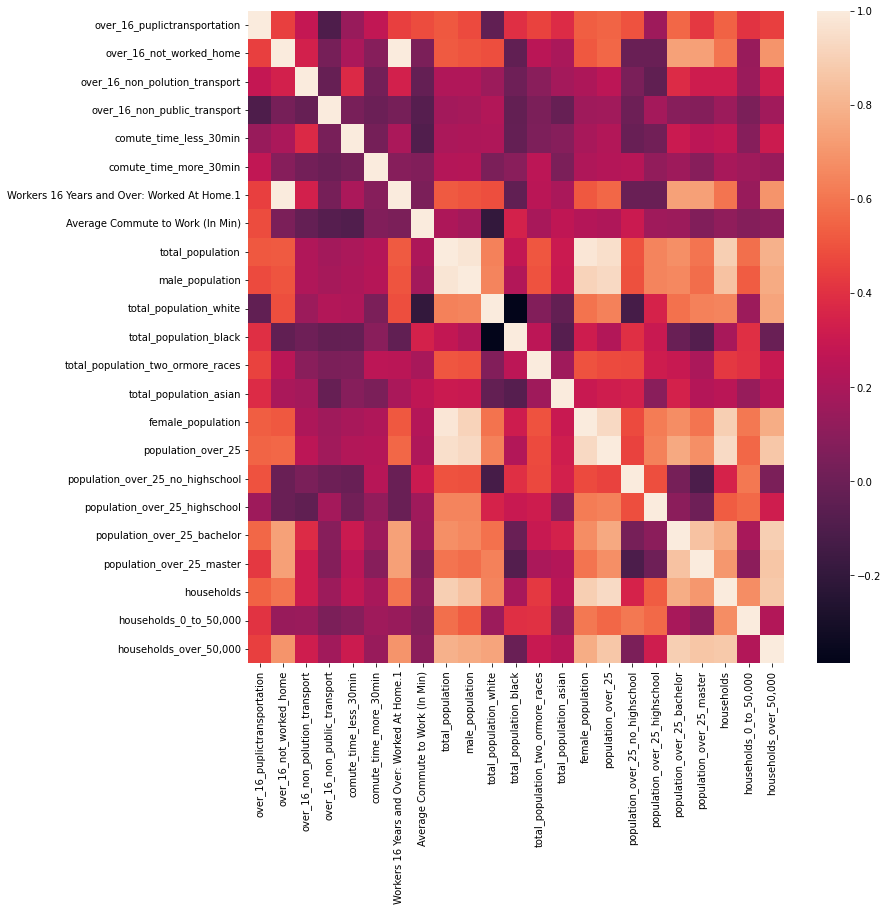

In [39]:
fig, ax = plt.subplots(1, figsize=(12,12))
corr = combined[corr_columns].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [40]:
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


<AxesSubplot:>

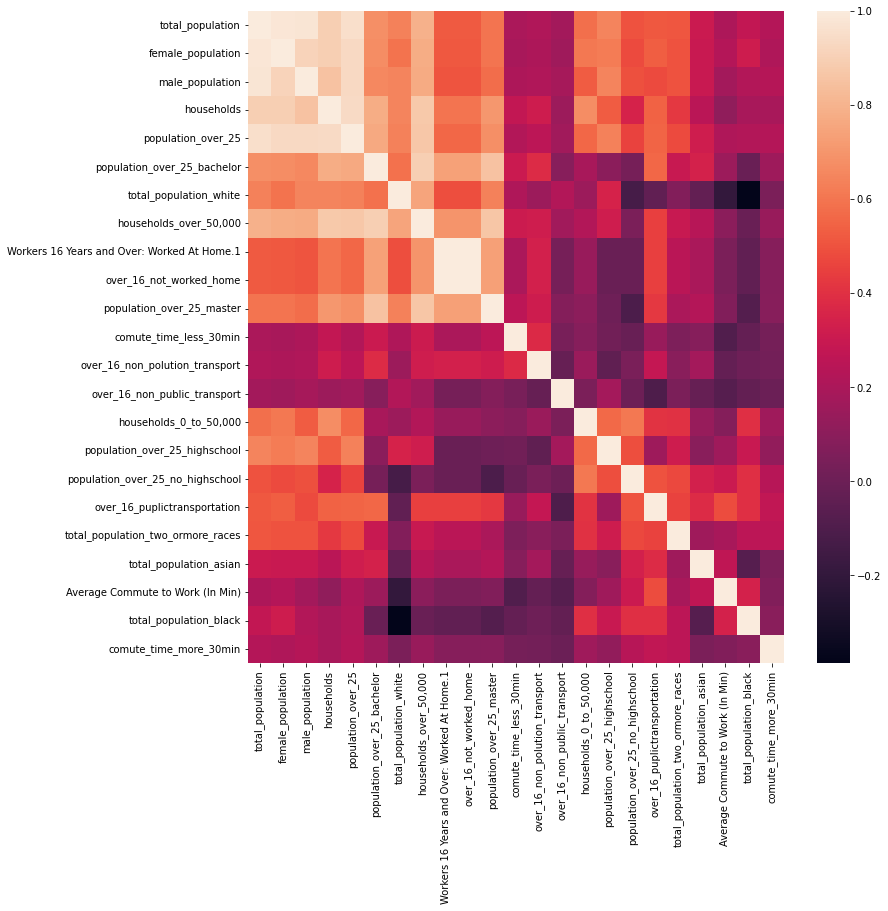

In [41]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(combined[corr_columns].corr()))


In [42]:
combined = combined.to_crs("EPSG:4326")
combined.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Analysis

In [43]:
#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis', basemap=None, ax=None):  
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df.plot.scatter(ax=ax, x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    if basemap:
        ctx.add_basemap(ax=ax, crs=basemap)

    plt.xticks([], []); plt.yticks([], [])
    return ax
    

In [44]:
#Declare the directory path for the GTFS zip file
path = 'nyc/gtfs_zips/subway_gtfs.zip'

#Read the feed with gtfs-kit
feed = (gk.read_feed(path, dist_units='km'))

In [45]:
#Search for errors and warnings in the feed
feed.validate()

type                 message  table  \
0  warning  Stop has no stop times  stops   

                                       rows  
0  [112, 113, 1046, 1087, 1088, 1294, 1295]

In [46]:
feed.describe()

indicator                        value
0                           agencies  [MTA New York City Transit]
1                           timezone             America/New_York
2                         start_date                     20211219
3                           end_date                     20220625
4                         num_routes                           30
5                          num_trips                        68000
6                          num_stops                         1497
7                         num_shapes                          224
8                        sample_date                     20211223
9   num_routes_active_on_sample_date                           29
10   num_trips_active_on_sample_date                         8322
11   num_stops_active_on_sample_date                          991

In [47]:
stops = feed.get_stops()
stops_geo = gpd.GeoDataFrame(
    stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat))

stops_geo = stops_geo.set_crs('EPSG:4326')

clean_stops_geo = stops_geo[(~stops_geo['geometry'].is_empty)&
                                      (~stops_geo['geometry'].isna())]

In [48]:
clean_stops_geo

stop_id                  stop_name   stop_lat   stop_lon  location_type  \
0        101  Van Cortlandt Park-242 St  40.889248 -73.898583            1.0   
1       101N  Van Cortlandt Park-242 St  40.889248 -73.898583            NaN   
2       101S  Van Cortlandt Park-242 St  40.889248 -73.898583            NaN   
3        103                     238 St  40.884667 -73.900870            1.0   
4       103N                     238 St  40.884667 -73.900870            NaN   
...      ...                        ...        ...        ...            ...   
1492    S30N              Tompkinsville  40.636949 -74.074835            NaN   
1493    S30S              Tompkinsville  40.636949 -74.074835            NaN   
1494     S31                  St George  40.643748 -74.073643            1.0   
1495    S31N                  St George  40.643748 -74.073643            NaN   
1496    S31S                  St George  40.643748 -74.073643            NaN   

     parent_station                    geometry  
0               NaN  POINT (-73.89858 40.88925)  
1               101  POINT (-73.89858 40.88925)  
2               101  POINT (-73.89858 40.88925)  
3               NaN  POINT (-73.90087 40.88467)  
4               103  POINT (-73.90087 40.88467)  
...             ...                         ...  
1492            S30  POINT (-74.07483 40.63695)  
1493            S30  POINT (-74.07483 40.63695)  
1494            NaN  POINT (-74.07364 40.64375)  
1495            S31  POINT (-74.07364 40.64375)  
1496            S31  POINT (-74.07364 40.64375)  

[1497 rows x 7 columns]

In [49]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
stops[hex_col] = stops.apply(lambda x: h3.geo_to_h3(x.stop_lat,x.stop_lon,APERTURE_SIZE),1)

# aggregate the points
stopsg = stops.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
stopsg['stop_lat'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
stopsg['stop_lon'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

Text(0.5, 1.0, 'Subway')

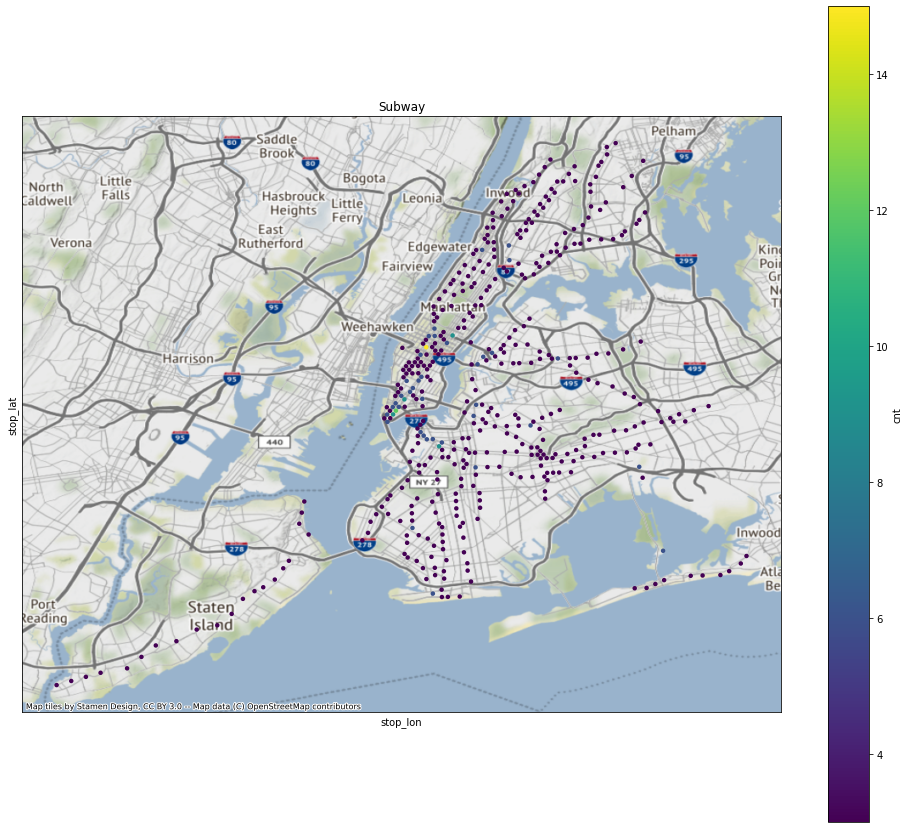

In [50]:
# pltot the hexs
plot_scatter(stopsg, metric_col='cnt', y="stop_lat", x="stop_lon", marker='o',figsize=(17,15), basemap=combined.crs.to_string())
plt.title('Subway')

In [51]:
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['stop_lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['stop_lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

sum sanity check: 1.0


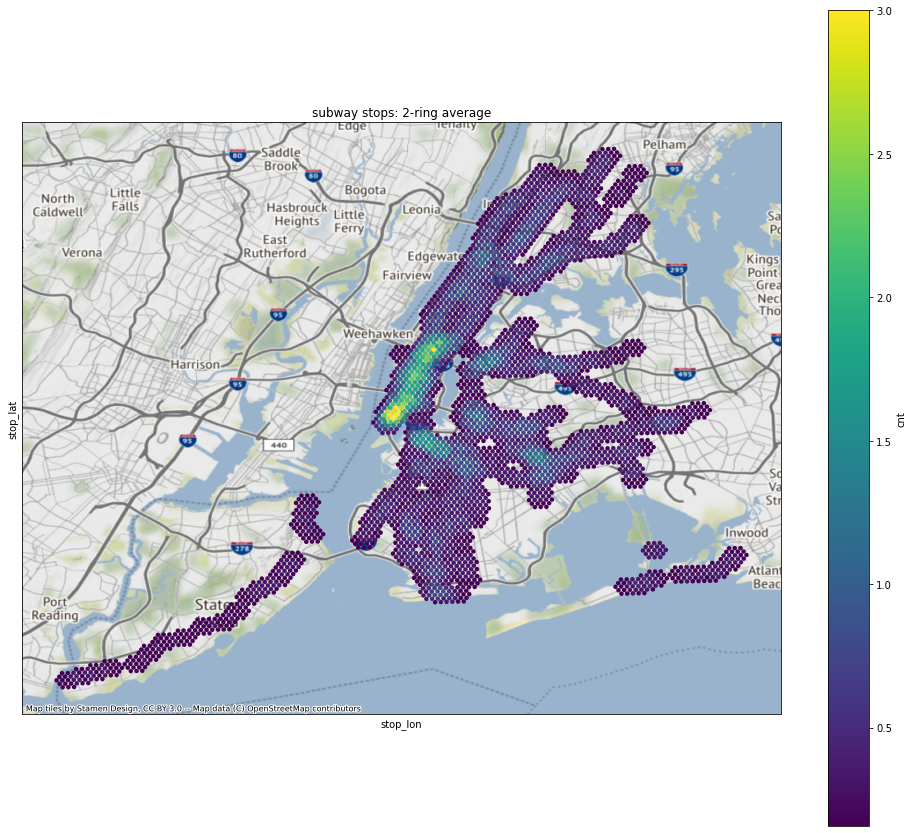

In [52]:
#kring_smoothing
k = 2
stops_kring= kring_smoothing(stopsg, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', stops_kring['cnt'].sum() / stopsg['cnt'].sum())

fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stops_kring.plot.scatter(ax=ax, x='stop_lon', y='stop_lat', c='cnt',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

ctx.add_basemap(ax=ax, crs="EPSG:4326")

In [53]:
stops_kring

hex9       cnt   stop_lat   stop_lon
0     892a100024fffff  0.157895  40.857328 -73.824784
1     892a1000263ffff  0.157895  40.852149 -73.820309
2     892a100026bffff  0.157895  40.852039 -73.824594
3     892a100026fffff  0.157895  40.849450 -73.822357
4     892a100027bffff  0.157895  40.854738 -73.822546
...               ...       ...        ...        ...
3368  892a10776a3ffff  0.157895  40.664876 -74.003763
3369  892a10776a7ffff  0.157895  40.662296 -74.001524
3370  892a10776afffff  0.157895  40.662180 -74.005792
3371  892a10776b3ffff  0.157895  40.667572 -74.001733
3372  892a10776b7ffff  0.315789  40.664992 -73.999494

[3373 rows x 4 columns]

In [54]:
stops_kring.describe()

cnt     stop_lat     stop_lon
count  3373.000000  3373.000000  3373.000000
mean      0.443819    40.711751   -73.941223
std       0.372201     0.096294     0.090029
min       0.157895    40.507331   -74.259713
25%       0.157895    40.639996   -73.982692
50%       0.315789    40.703090   -73.939739
75%       0.473684    40.784207   -73.880673
max       3.000000    40.907095   -73.747545

# Census to Hex
https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

In [55]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()[corr_columns + ["GEOID", "geometry"]]
gdf = gdf.to_crs("EPSG:4326")
# METRIC_COL = 'Workers 16 Years and Over: Public Transportation (Includes Taxicab)'
METRIC_COL = "over_16_puplictransportation"
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [56]:
gdf.columns

Index(['over_16_puplictransportation', 'over_16_not_worked_home',
       'over_16_non_polution_transport', 'over_16_non_public_transport',
       'comute_time_less_30min', 'comute_time_more_30min',
       'Workers 16 Years and Over: Worked At Home.1',
       'Average Commute to Work (In Min)', 'total_population',
       'male_population', 'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25',
       'population_over_25_no_highschool', 'population_over_25_highschool',
       'population_over_25_bachelor', 'population_over_25_master',
       'households', 'households_0_to_50,000', 'households_over_50,000',
       'GEOID', 'geometry'],
      dtype='object')

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


Text(0.5, 1.0, 'over_16_puplictransportation')

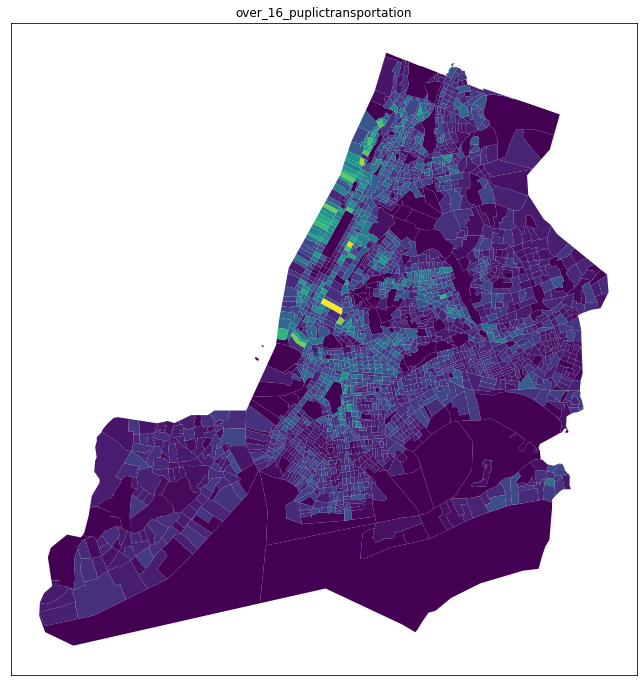

In [57]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('over_16_puplictransportation')

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


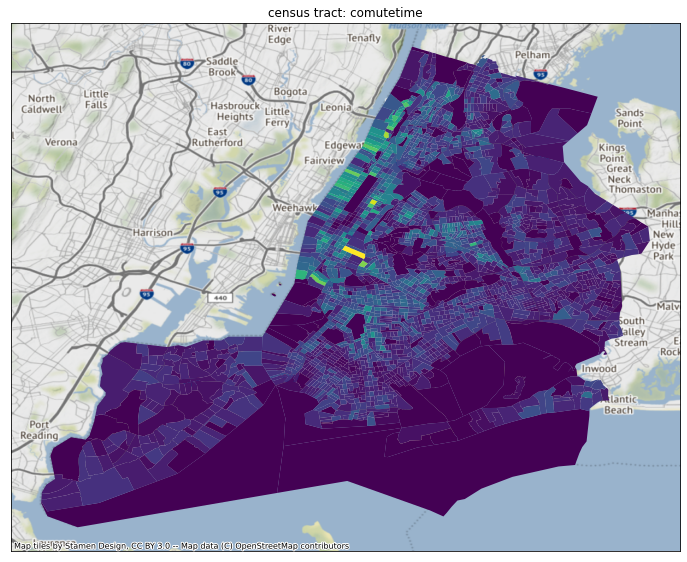

In [58]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: comutetime')
ctx.add_basemap(ax=ax, crs=gdf.crs)

In [59]:
# Unify the CT boundries
union_poly = gdf.geometry.unary_union

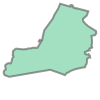

In [60]:
union_poly

In [61]:
APERTURE_SIZE = 9

In [62]:
# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

0 
1 
2 


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_37386/2716173586.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for n,g in enumerate(union_poly):


In [63]:
# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

Sanity Check
number of hexes: 11565
number of duplicates: 0


In [64]:
# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [65]:
# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)


/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [66]:
dfh.crs = {"init": "EPSG:4326"}

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_37386/3066430071.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfh.crs = {"init": "EPSG:4326"}


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_37386/2662139995.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  df_ct = gpd.tools.sjoin(gdf, dfh, how="inner")


over_16_puplictransportation  over_16_not_worked_home  \
1561                             0                        0   
1268                           483                       41   
4293                          1001                      216   

      over_16_non_polution_transport  over_16_non_public_transport  \
1561                               0                             0   
1268                            1181                13811193188018   
4293                            8108                   73831142700   

      comute_time_less_30min  comute_time_more_30min  \
1561                       0                       0   
1268               143290221            322400263335   
4293                17126153             19541486090   

      Workers 16 Years and Over: Worked At Home.1  \
1561                                            0   
1268                                           41   
4293                                          216   

      Average Commute to Work (In Min)  total_population  male_population  \
1561                                 0                 0                0   
1268                                45              4331             2067   
4293                                50              4419             2185   

      ...  population_over_25_master  households  households_0_to_50,000  \
1561  ...                          0           0                       0   
1268  ...                        313        1513                     350   
4293  ...                        597        1705                     679   

      households_over_50,000        GEOID  \
1561                       0  36061031100   
1268                    1163  36085009701   
4293                    1026  36047038800   

                                               geometry  index_right  \
1561  POLYGON ((-73.94037 40.83147, -73.94035 40.831...         9607   
1268  POLYGON ((-74.12096 40.64400, -74.11929 40.644...        10798   
4293  POLYGON ((-73.97190 40.59435, -73.97176 40.595...         5074   

                 hex9        lat        lng  
1561  892a100ae23ffff  40.846662 -73.929477  
1268  892a10624afffff  40.640818 -74.109583  
4293  892a10740b7ffff  40.591965 -73.966754  

[3 rows x 29 columns]

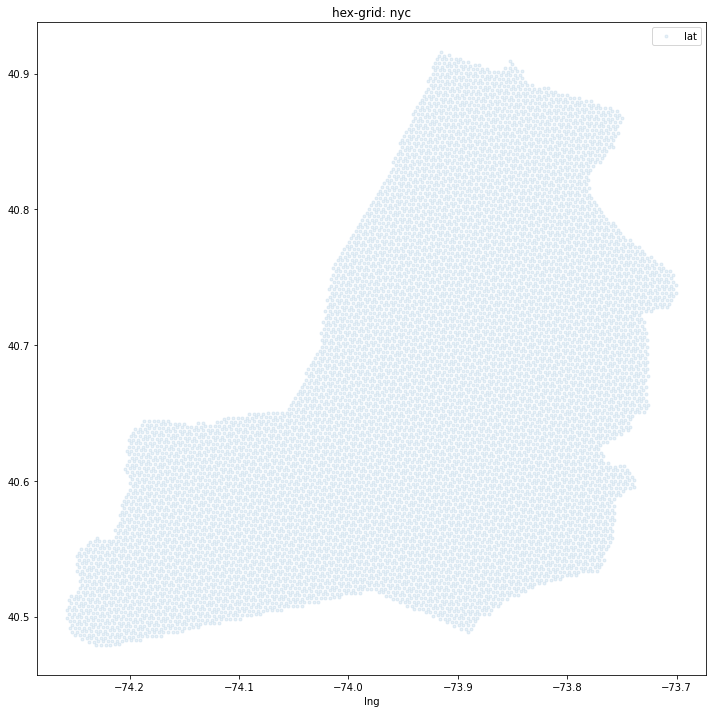

In [67]:
# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
dfh = GeoDataFrame(dfh)
# Intersect Hex Point with CT Polygon
df_ct = gpd.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)


In [68]:
df_ct[METRIC_COL] = df_ct[METRIC_COL].astype(int)

<AxesSubplot:title={'center':'over_16_puplictransportation'}, xlabel='lng', ylabel='lat'>

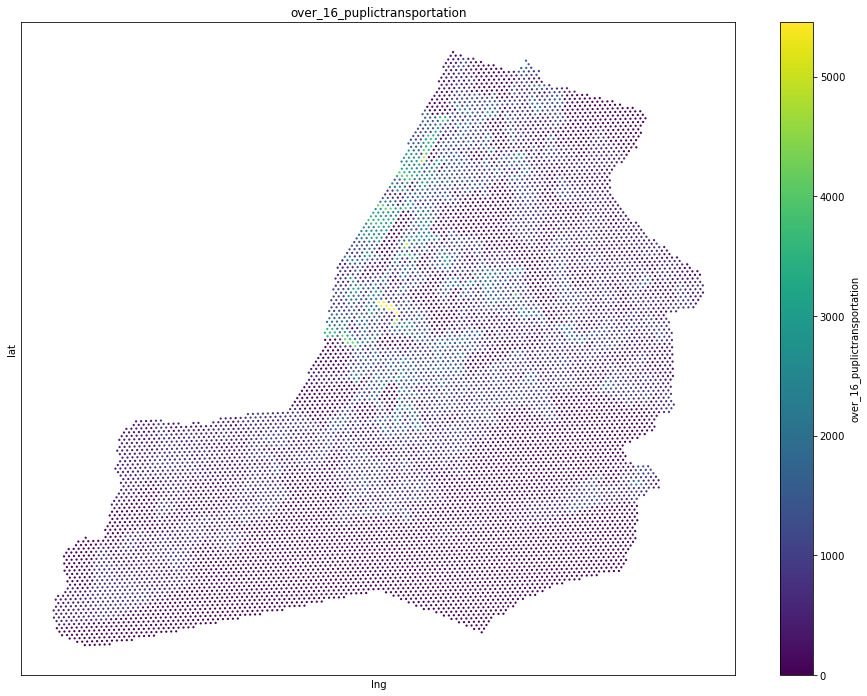

In [69]:
plot_scatter(pd.DataFrame(df_ct), metric_col=METRIC_COL, marker='.')

# Spatial weight smoothing

In [70]:
def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

In [71]:
def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc


Text(0, 0.5, 'Smoothing Coef')

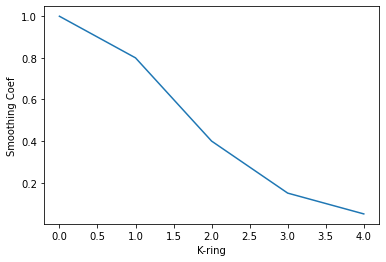

In [72]:
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

In [73]:
# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(df_ct, hex_col, metric_col=METRIC_COL, coef=coef)

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_37386/360021348.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['hexk'] = df_agg[hex_col]


In [74]:
print('sum sanity check:', df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())

sum sanity check: 1.0000000000000002


Text(0.5, 1.0, 'hex-grid: smoothed comute time')

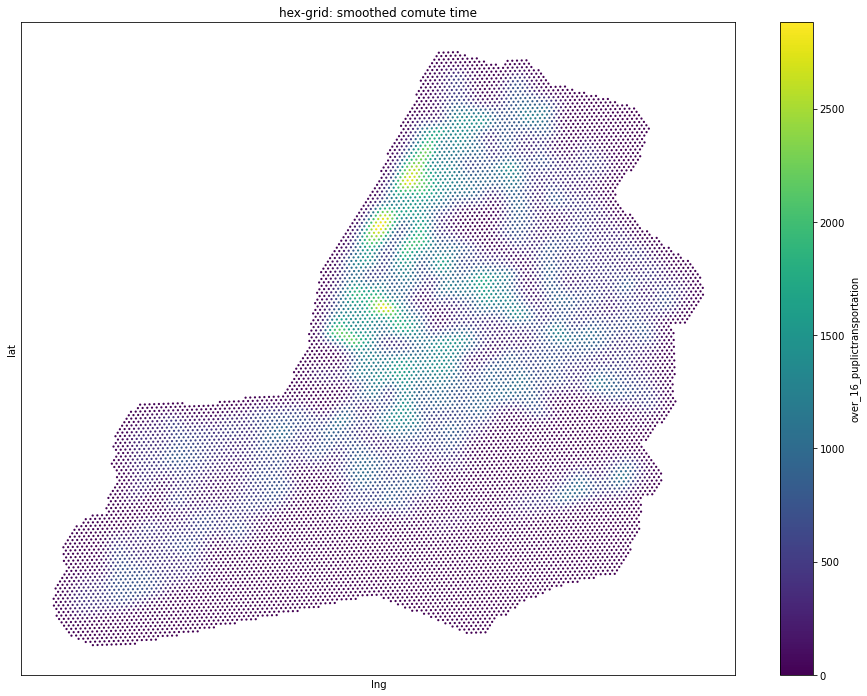

In [75]:
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: smoothed comute time')

In [76]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 9
df_coarse = aperture_downsampling(df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))

number of hex: 13760
number of coarse hex: 13760


In [77]:
df_coarse

hex9  over_16_puplictransportation        lat        lng
0      892a1000003ffff                    108.800000  40.858416 -73.781928
1      892a1000007ffff                    112.551724  40.855826 -73.779693
2      892a100000bffff                    176.331034  40.858308 -73.786214
3      892a100000fffff                    211.972414  40.855718 -73.783978
4      892a1000013ffff                     39.393103  40.861115 -73.779877
...                ...                           ...        ...        ...
13755  892a10776cbffff                    280.800000  40.674963 -74.021257
13756  892a10776cfffff                    221.255172  40.672383 -74.019017
13757  892a10776d3ffff                    300.337931  40.677777 -74.014958
13758  892a10776d7ffff                    352.600000  40.675197 -74.012718
13759  892a10776dbffff                    272.006897  40.677660 -74.019227

[13760 rows x 4 columns]

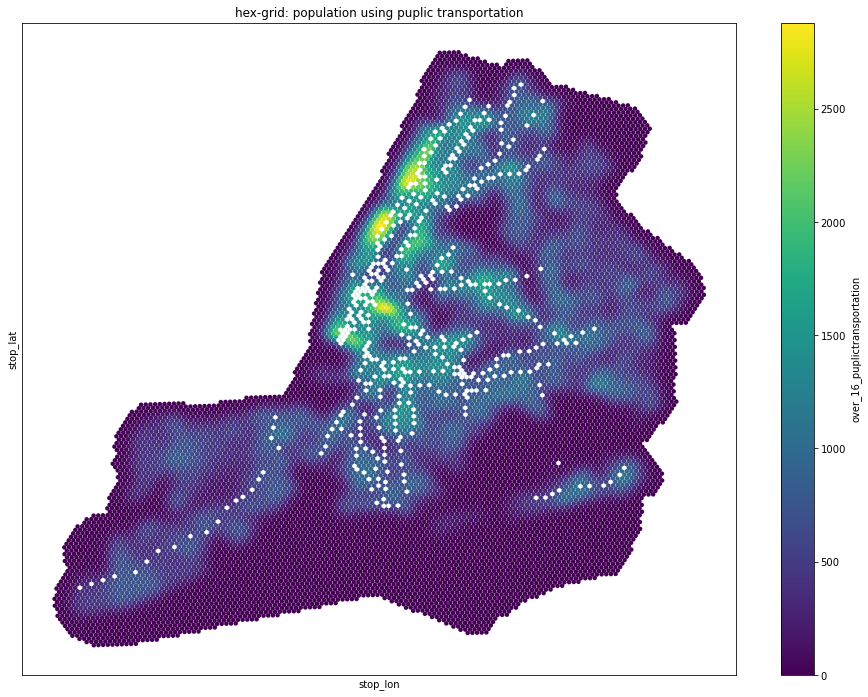

In [78]:
ax = plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
stopsg.plot.scatter(ax=ax, y="stop_lat",c="white", x="stop_lon", marker='o',edgecolors='none')
plt.title('hex-grid: population using puplic transportation');

## Unifying data layers

over_16_puplictransportation        stop
count                    447.000000  447.000000
mean                    1093.926822    3.348993
std                      478.855257    1.204957
min                       53.400000    3.000000
25%                      712.737931    3.000000
50%                     1039.896552    3.000000
75%                     1368.729310    3.000000
max                     2811.751724   15.000000

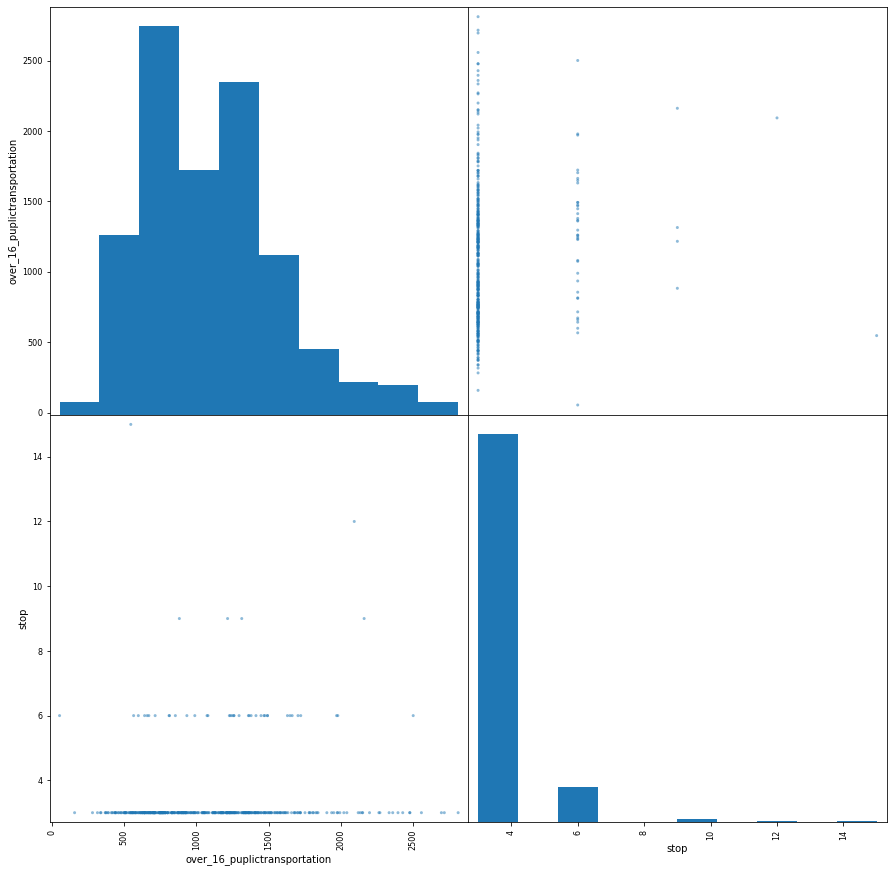

In [79]:
dfu = df_coarse[[METRIC_COL,hex_col]].merge(stopsg[[hex_col,'cnt']].rename(columns={"cnt":"stop"}))
dfu.set_index(hex_col,inplace=True)
pd.plotting.scatter_matrix(dfu, alpha=0.5,figsize=(15,15));
# dfu['lat']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[0])
# dfu['lng']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[1])
dfu.describe()

# Morans I Analysis

In [80]:
import esda
from pysal.lib import weights
import seaborn as sns
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights

In [81]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()[corr_columns + ["GEOID", "geometry"]]
gdf = gdf.to_crs("EPSG:4326")

gdf.head().T

0  \
over_16_puplictransportation                                                              1471   
over_16_not_worked_home                                                                    303   
over_16_non_polution_transport                                                           45256   
over_16_non_public_transport                                                         112516100   
comute_time_less_30min                                                               132165316   
comute_time_more_30min                                                             63248139119   
Workers 16 Years and Over: Worked At Home.1                                                303   
Average Commute to Work (In Min)                                                            36   
total_population                                                                          3899   
male_population                                                                           1945   
total_population_white                                                                    3303   
total_population_black                                                                      99   
total_population_two_ormore_races                                                          348   
total_population_asian                                                                      90   
female_population                                                                         1954   
population_over_25                                                                        2749   
population_over_25_no_highschool                                                            67   
population_over_25_highschool                                                              139   
population_over_25_bachelor                                                               1142   
population_over_25_master                                                                  728   
households                                                                                1669   
households_0_to_50,000                                                                     264   
households_over_50,000                                                                    1405   
GEOID                                                                              36047000700   
geometry                                     POLYGON ((-74.001542 40.692786, -74.001317 40....   

                                                                                             1  \
over_16_puplictransportation                                                              2112   
over_16_not_worked_home                                                                    613   
over_16_non_polution_transport                                                           63353   
over_16_non_public_transport                                                          73730026   
comute_time_less_30min                                                               181565494   
comute_time_more_30min                                                              7515452566   
Workers 16 Years and Over: Worked At Home.1                                                613   
Average Commute to Work (In Min)                                                            29   
total_population                                                                          4654   
male_population                                                                           2258   
total_population_white                                                                    3591   
total_population_black                                                                     177   
total_population_two_ormore_races                                                          394   
total_population_asian                                                                     469   
female_population                                                         

In [82]:
METRIC_COL = "comute_time_more_30min"
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [83]:
gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

In [84]:
gdf.head()

over_16_puplictransportation  over_16_not_worked_home  \
0                          1471                      303   
1                          2112                      613   
2                           795                      151   
3                           481                      221   
4                           332                        0   

   over_16_non_polution_transport  over_16_non_public_transport  \
0                           45256                     112516100   
1                           63353                      73730026   
2                            1969                     574512495   
3                           37136                       8787000   
4                             147                      68491900   

   comute_time_less_30min  comute_time_more_30min  \
0               132165316            6.324814e+10   
1               181565494            7.515453e+09   
2                30222191            2.971965e+09   
3                33135110            1.952653e+07   
4                  225372            1.681335e+09   

   Workers 16 Years and Over: Worked At Home.1  \
0                                          303   
1                                          613   
2                                          151   
3                                          221   
4                                            0   

   Average Commute to Work (In Min)  total_population  male_population  ...  \
0                                36              3899             1945  ...   
1                                29              4654             2258  ...   
2                                32              1502              929  ...   
3                                30              1917              994  ...   
4                                39              1503              722  ...   

   population_over_25  population_over_25_no_highschool  \
0                2749                                67   
1                3714                                87   
2                1279                                11   
3                1574                                22   
4                 799                               416   

   population_over_25_highschool  population_over_25_bachelor  \
0                            139                         1142   
1                             96                         1633   
2                             60                          581   
3                            192                          387   
4                            218                          130   

   population_over_25_master  households  households_0_to_50,000  \
0                        728        1669                     264   
1                       1011        2284                     164   
2                        334         818                      90   
3                        540        1021                     294   
4                          0         388                     224   

   households_over_50,000        GEOID  \
0                    1405  36047000700   
1                    2120  36047000900   
2                     728  36047001100   
3                     727  36047001300   
4                     164  36047002000   

                                            geometry  
0  POLYGON ((-74.00154 40.69279, -74.00132 40.693...  
1  POLYGON ((-73.99405 40.69090, -73.99374 40.691...  
2  POLYGON ((-73.99073 40.69305, -73.99045 40.693...  
3  POLYGON ((-73.99141 40.69863, -73.99131 40.699...  
4  POLYGON ((-74.01867 40.64741, -74.01809 40.647...  

[5 rows x 25 columns]

In [85]:
sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["GEOID", "geometry"] + [METRIC_COL]], how="right", predicate='intersects')

In [86]:
gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", METRIC_COL, "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()


In [87]:
gdf.head()

GEOID                                           geometry  \
0  36047000700  POLYGON ((-74.00154 40.69279, -74.00132 40.693...   
1  36047000900  POLYGON ((-73.99405 40.69090, -73.99374 40.691...   
2  36047001100  POLYGON ((-73.99073 40.69305, -73.99045 40.693...   
4  36047001300  POLYGON ((-73.99141 40.69863, -73.99131 40.699...   
5  36047002000  POLYGON ((-74.01867 40.64741, -74.01809 40.647...   

   comute_time_more_30min  Total_num_stops  
0            6.324814e+10              0.0  
1            7.515453e+09              3.0  
2            2.971965e+09             12.0  
4            1.952653e+07              3.0  
5            1.681335e+09              0.0

In [88]:
w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 36061000100.
  warnings.warn(message)


<AxesSubplot:>

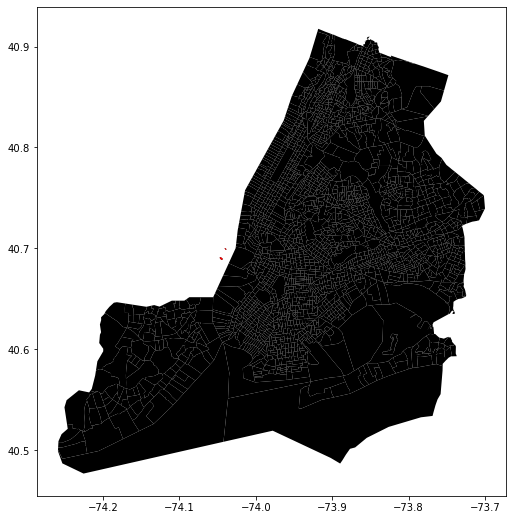

In [89]:
ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

In [90]:
gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [91]:
%time w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

CPU times: user 606 ms, sys: 4.6 ms, total: 610 ms
Wall time: 610 ms


In [92]:
# Row standardize the matrix
w.transform = 'R'

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)


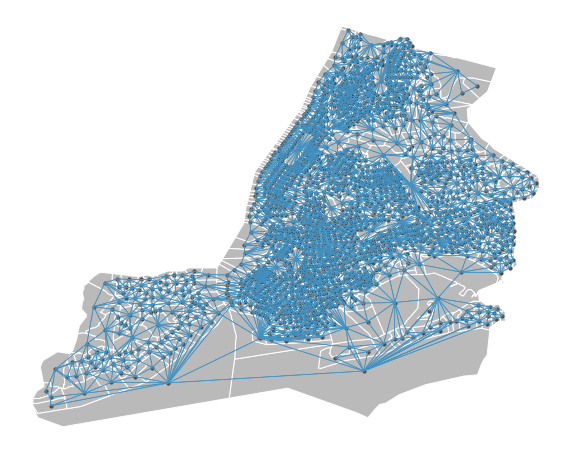

In [93]:
plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

In [94]:
gdf['w_avg_com'] = weights.lag_spatial(w, gdf[METRIC_COL])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

In [95]:
gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

In [96]:
gdf['avg_com_std'] = (
    gdf[METRIC_COL] - gdf[METRIC_COL].mean()
) / gdf[METRIC_COL].std()

In [97]:
gdf.head()

GEOID                                           geometry  \
0  36047000700  POLYGON ((-74.00154 40.69279, -74.00132 40.693...   
1  36047000900  POLYGON ((-73.99405 40.69090, -73.99374 40.691...   
2  36047001100  POLYGON ((-73.99073 40.69305, -73.99045 40.693...   
3  36047001300  POLYGON ((-73.99141 40.69863, -73.99131 40.699...   
4  36047002000  POLYGON ((-74.01867 40.64741, -74.01809 40.647...   

   comute_time_more_30min  Total_num_stops     w_avg_com  w_Total_num_stops  \
0            6.324814e+10              0.0  1.308478e+11           0.000000   
1            7.515453e+09              3.0  1.425742e+11           3.000000   
2            2.971965e+09             12.0  1.530185e+11           1.285714   
3            1.952653e+07              3.0  1.026085e+10           3.000000   
4            1.681335e+09              0.0  1.257199e+11           0.428571   

   Total_num_stops_std  avg_com_std  
0             -0.39554    -0.095252  
1              1.44820    -0.106694  
2              6.97942    -0.107627  
3              1.44820    -0.108233  
4             -0.39554    -0.107892

In [98]:
gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

In [99]:
gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

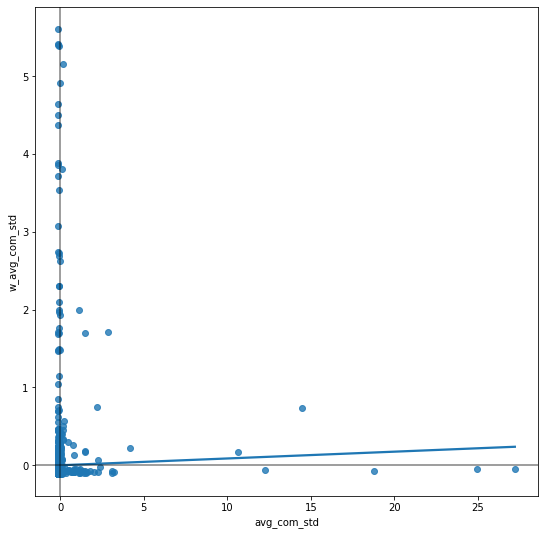

In [100]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

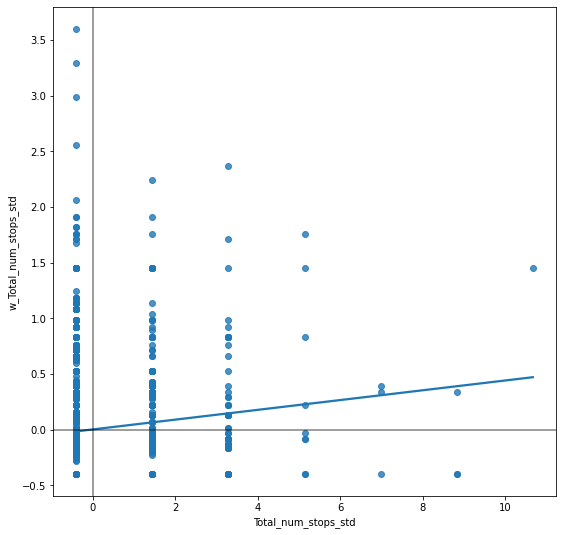

In [101]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [102]:
mi = esda.Moran(gdf[METRIC_COL], w)
mi.I, mi.p_sim

(0.008739557416180651, 0.059)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.01)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

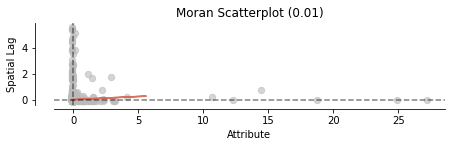

In [103]:
moran_scatterplot(mi)

In [104]:
mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

(0.043984303191008635, 0.001)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.04)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

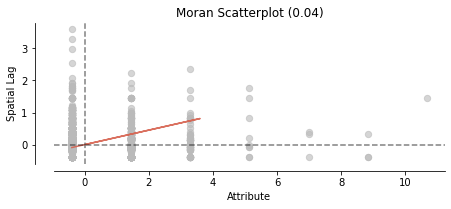

In [105]:
moran_scatterplot(mi)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.04', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.04)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

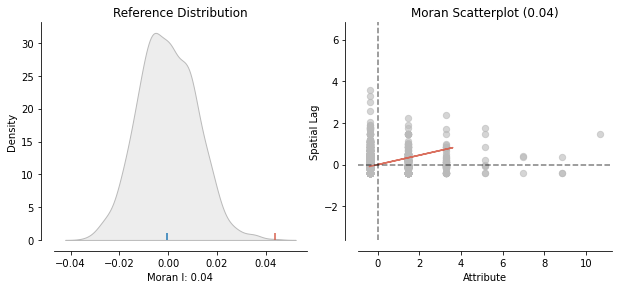

In [106]:
plot_moran(mi)

In [107]:
lisa = esda.Moran_Local(gdf[METRIC_COL], w)

In [108]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

In [109]:
gdf['significant'].head()

0    False
1    False
2    False
3     True
4    False
Name: significant, dtype: bool

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

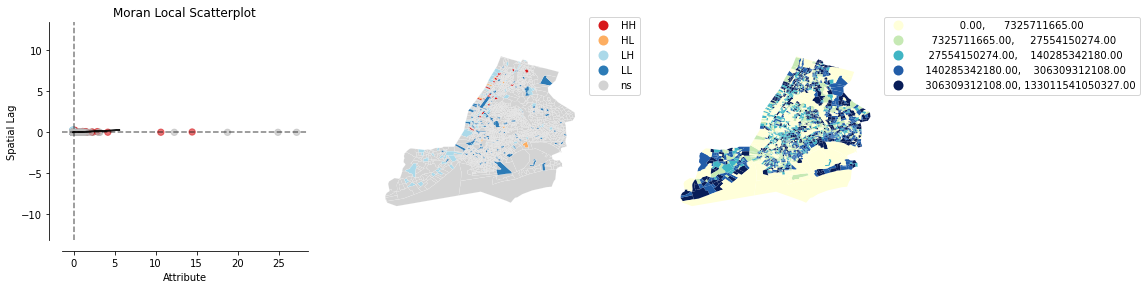

In [110]:
plot_local_autocorrelation(lisa, gdf, METRIC_COL)

In [111]:
lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

In [112]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

In [113]:
gdf['significant'].head()

0    False
1     True
2    False
3     True
4    False
Name: significant, dtype: bool

## Spatial analysis

In [295]:
gdf = combined.copy()[corr_columns + ["GEOID", "geometry"]]
gdf = gdf.to_crs("EPSG:4326")

In [296]:
sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf, how="right", predicate='intersects').drop(columns=["index_left"]).fillna(0)

In [297]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [298]:
gdf.columns

Index(['cnt', 'over_16_puplictransportation', 'over_16_not_worked_home',
       'over_16_non_polution_transport', 'over_16_non_public_transport',
       'comute_time_less_30min', 'comute_time_more_30min',
       'Workers 16 Years and Over: Worked At Home.1',
       'Average Commute to Work (In Min)', 'total_population',
       'male_population', 'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25',
       'population_over_25_no_highschool', 'population_over_25_highschool',
       'population_over_25_bachelor', 'population_over_25_master',
       'households', 'households_0_to_50,000', 'households_over_50,000',
       'GEOID', 'geometry'],
      dtype='object')

In [314]:
transport_cols = ['over_16_not_worked_home','over_16_non_polution_transport', 'over_16_non_public_transport','Workers 16 Years and Over: Worked At Home.1', 'over_16_puplictransportation']
commutetime_cols = ['comute_time_less_30min', 'comute_time_more_30min']
skintone_cols = [ 'total_population_white', 'total_population_black','total_population_two_ormore_races', 'total_population_asian']
gender_cols = ["male_population", "female_population"]
edu_cols = ['population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master']
household_cols = ['households_0_to_50,000',
       'households_over_50,000']
stops_cols = ['cnt', 'Average Commute to Work (In Min)']

target_col = 'over_16_non_public_transport'


In [315]:
regression_df = gdf.copy()

In [316]:
regression_df[transport_cols] = regression_df[transport_cols].div(regression_df[transport_cols].sum(axis=1), axis=0)
regression_df[commutetime_cols] = regression_df[commutetime_cols].div(regression_df[commutetime_cols].sum(axis=1), axis=0)
regression_df[skintone_cols] = regression_df[skintone_cols].div(regression_df[skintone_cols].sum(axis=1), axis=0)
regression_df[gender_cols] = regression_df[gender_cols].div(regression_df[gender_cols].sum(axis=1), axis=0)
regression_df[edu_cols] = regression_df[edu_cols].div(regression_df[edu_cols].sum(axis=1), axis=0)
regression_df[household_cols] = regression_df[household_cols].div(regression_df[household_cols].sum(axis=1), axis=0)


In [327]:
feature_col = transport_cols + commutetime_cols + skintone_cols + gender_cols + edu_cols + household_cols + stops_cols
target_col = 'over_16_non_public_transport'
feature_col = [col for col in feature_col if col not in [target_col]]

In [328]:
regression_df = regression_df.apply(
    func=lambda x: pd.to_numeric(arg=x, errors="ignore", downcast="float"),
    axis=0).fillna(0)

In [329]:
X_train, X_test, y_train, y_test = train_test_split(regression_df[feature_col], regression_df[target_col].values, test_size=0.33, random_state=42)

In [330]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
cols = X_train.columns
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [331]:
reg = LinearRegression().fit(X_train, y_train)

In [332]:
preds = reg.predict(X_test)

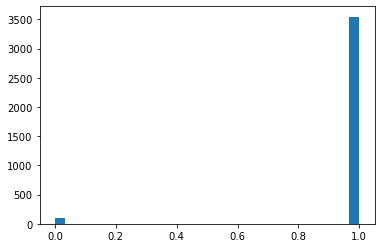

0.9717758 0.16486207


In [333]:
plt.hist(y_train, bins=30)
plt.show()
print(np.array(y_train).mean(),np.array(y_train).std())

In [334]:
reg.coef_

array([-8.0518937e-03, -2.5457561e-02, -8.0518695e-03, -3.7281934e-02,
        3.1450027e-01,  3.3312941e-01,  3.5576659e-04,  2.0019349e-04,
        2.9757360e-04,  2.5451728e-04,  2.3599495e-03,  6.1633095e-06,
       -8.1904343e-04,  7.5534568e-04,  3.8324465e-04,  1.1123682e-03,
        1.0834148e-02,  9.7822528e-03,  3.6510479e-04,  1.1356275e-03],
      dtype=float32)

In [335]:
np.array(feature_col)[idx]

array(['Workers 16 Years and Over: Worked At Home.1',
       'over_16_non_polution_transport', 'over_16_not_worked_home',
       'over_16_puplictransportation', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'Average Commute to Work (In Min)',
       'total_population_two_ormore_races', 'cnt',
       'total_population_asian', 'total_population_white',
       'total_population_black', 'female_population',
       'households_over_50,000', 'households_0_to_50,000',
       'male_population', 'comute_time_less_30min',
       'comute_time_more_30min'], dtype='<U43')

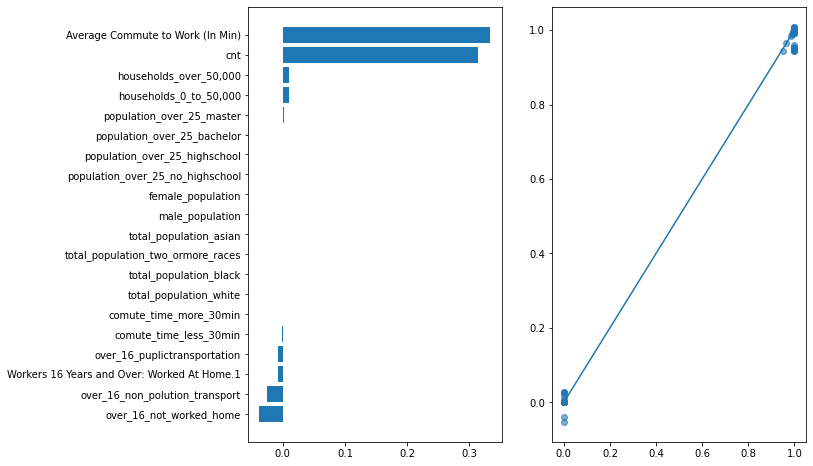

(0.004377704, 0.9992295199292556)

In [336]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(reg.coef_)
ax[0].barh(cols,reg.coef_[idx])

ax[1].scatter(y_test, preds, alpha=0.6)
ax[1].plot([0,1])
plt.show()
mean_squared_error(y_test, preds, squared=False), r2_score(y_test, preds)

In [291]:
feature_col = [col for col in feature_col if col not in ["cnt", "Average Commute to Work (In Min)"]]

X_train, X_test, y_train, y_test = train_test_split(gdf[feature_col], gdf[target_col], test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
preds = reg.predict(X_test)


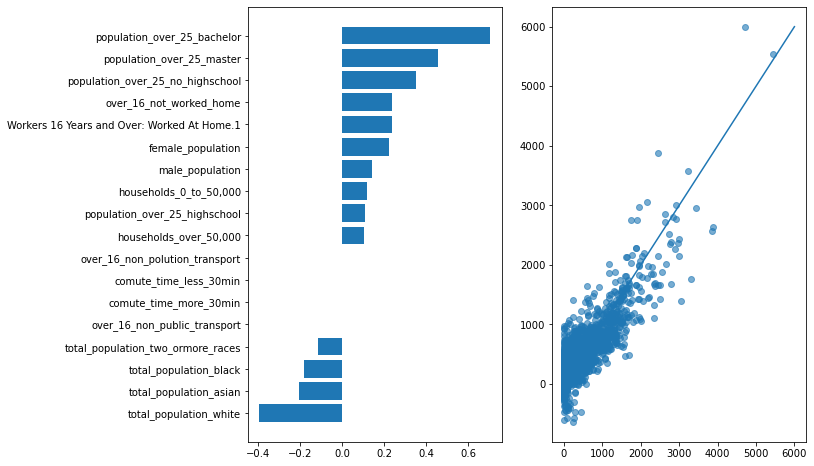

(306.7468729003992, 0.7398732502149319)

In [195]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(reg.coef_)
ax[0].barh(X_train.columns[idx],reg.coef_[idx])

ax[1].scatter(y_test, preds, alpha=0.6)
ax[1].plot([x for x in range(6000)])
plt.show()
mean_squared_error(y_test, preds, squared=False), r2_score(y_test, preds)

In [196]:
X_train.head()

over_16_not_worked_home  over_16_non_polution_transport  \
1642                        6                            1275   
4195                       74                          136164   
4036                      129                              67   
3418                      134                              96   
2314                        0                              55   

      over_16_non_public_transport  \
1642                    7316527900   
4195                    1721621000   
4036                    2031703300   
3418                   76268379070   
2314                   83079436017   

      Workers 16 Years and Over: Worked At Home.1  comute_time_less_30min  \
1642                                            6               374216117   
4195                                           74                36116246   
4036                                          129                 6034150   
3418                                          134                 5203179   
2314                                            0               101479142   

      comute_time_more_30min  total_population_white  total_population_black  \
1642                 6043314                    1433                      55   
4195             36880033241                    1482                    1923   
4036             42045036120                    1774                     100   
3418            283140281156                      43                    2339   
2314                31533660                    1695                       0   

      total_population_two_ormore_races  total_population_asian  \
1642                                154                      54   
4195                                102                     100   
4036                                146                     185   
3418                                 43                       7   
2314                                 53                       0   

      male_population  female_population  population_over_25_no_highschool  \
1642             1201               1386                               251   
4195             1901               1912                               514   
4036             1375               1207                               151   
3418             1301               1321                               223   
2314              883                998                               123   

      population_over_25_highschool  population_over_25_bachelor  \
1642                            745                          127   
4195                            844                          957   
4036                            334                          876   
3418                            567                          201   
2314                            405                          172   

      population_over_25_master  households_0_to_50,000  \
1642                         57                     758   
4195                        337                     760   
4036                        141                     312   
3418                        156                     174   
2314                        179                     382   

      households_over_50,000  
1642                     324  
4195                     784  
4036                     873  
3418                     649  
2314                     435

In [ ]:


fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(reg.coef_)
ax[0].barh(X_train.columns[idx],reg.coef_[idx])

points = ax[1].scatter(y_test, preds, alpha=0.6, c = X_test["population_over_25_bachelor"])
ax[1].plot([x for x in range(6000)])
plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y_test, preds, squared=False), r2_score(y_test, preds)

In [ ]:
X_train.columns

In [ ]:
plt.scatter()